In [766]:
import cv2
import os
import torch
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, transforms
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import pandas as pd


In [767]:
dataset_path = Path('icg-freshers-data-science-competition/Dataset/')
train_path = dataset_path/"Train"
test_path = dataset_path/"Test"

In [768]:
train_path

PosixPath('icg-freshers-data-science-competition/Dataset/Train')

In [769]:
# count
for x, y, z in os.walk('icg-freshers-data-science-competition/Dataset/'):
    print(x,y,z)

icg-freshers-data-science-competition/Dataset/ ['Train', 'Test'] ['Sample_submission.csv']
icg-freshers-data-science-competition/Dataset/Train ['Zeroes_and_Crosses', 'Grids'] ['.~lock.Grid_labels.csv#', 'Grid_labels.csv']
icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses ['Zeroes', 'Cross'] []
icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes [] ['594.png', '611.png', '607.png', '597.png', '614.png', '599.png', '596.png', '601.png', '618.png', '609.png', '602.png', '617.png', '616.png', '604.png', '598.png', '613.png', '605.png', '595.png', '612.png', '610.png', '600.png', '615.png', '603.png', '606.png', '608.png']
icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Cross [] ['188.png', '195.png', '201.png', '185.png', '183.png', '184.png', '200.png', '194.png', '197.png', '191.png', '203.png', '189.png', '187.png', '205.png', '196.png', '204.png', '193.png', '202.png', '192.png', '186.png', '199.png', '190.png', '182

In [770]:
Path.cwd()

PosixPath('/home/aarush/Aarush/Coding/ICG Project')

In [771]:
train_images = list(train_path.glob("*/*/*.png"))
test_images = list(test_path.glob("*.png"))
train_images

[PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/594.png'),
 PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/611.png'),
 PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/607.png'),
 PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/597.png'),
 PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/614.png'),
 PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/599.png'),
 PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/596.png'),
 PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/601.png'),
 PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/618.png'),
 PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/6

In [772]:
len(train_images),len(test_images)

(50, 4495)

In [773]:
img = Image.open(train_images[2])

In [774]:
np.asarray(img).shape

(28, 28)

In [775]:
data_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

In [776]:
train_data = datasets.ImageFolder(root=Path.joinpath(train_path,"Zeroes_and_Crosses"), # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

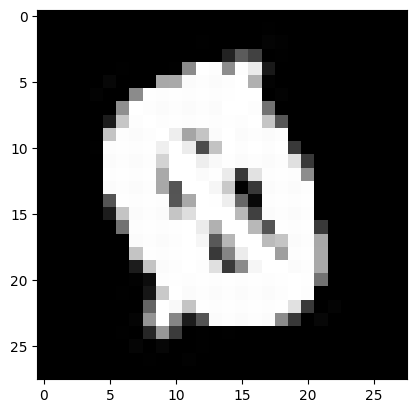

In [777]:

img = train_data[3][0]
img_permute = img.permute(1, 2, 0)
plt.imshow(img_permute)

In [778]:
train_data.classes

['Cross', 'Zeroes']

In [779]:
len(train_data)

50

In [780]:
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=1, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?


In [781]:
next(iter(train_dataloader))[0].shape

torch.Size([1, 3, 28, 28])

In [782]:
flatten_model = nn.Flatten()

In [783]:
# Create a convolutional neural network 
class Model_for_checking_0orX(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# optio784*100*100*10*60000/32ns = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(42)
model = Model_for_checking_0orX(input_shape=3, 
    hidden_units=100, 
    output_shape=len(train_data.classes))
model

Model_for_checking_0orX(
  (block_1): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4900, out_features=2, bias=True)
  )
)

In [784]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),lr=0.01)

In [785]:
def accuracy_function(y_pred,y):
    return torch.eq(y_pred.argmax(1),y).sum().item()/len(y_pred)*100

In [786]:
train_loss, train_acc = 0, 0
epochs = 20
for epoch in range(epochs):
    train_loss = 0
    train_accuracy = 0
    for Batch,(X,y) in enumerate(iter(train_dataloader)):
        model.train()
        y_pred = model(X)
        loss = loss_fn(y_pred,y)
        train_loss +=loss
        accuracy = accuracy_function(y_pred,y) 
        train_accuracy+=accuracy
        optimizer.zero_grad()
        loss.backward()
        # print(loss)
        optimizer.step()
    print(f"\n{epoch}|Average loss: {(train_loss/len(train_dataloader))}|Average Accuracy:{(train_accuracy/len(train_dataloader))}%\n")


0|Average loss: 0.7019031643867493|Average Accuracy:46.0%


1|Average loss: 0.6953052282333374|Average Accuracy:48.0%


2|Average loss: 0.6904139518737793|Average Accuracy:54.0%


3|Average loss: 0.6832519769668579|Average Accuracy:58.0%


4|Average loss: 0.6756300330162048|Average Accuracy:54.0%


5|Average loss: 0.6594074368476868|Average Accuracy:76.0%


6|Average loss: 0.6157457232475281|Average Accuracy:74.0%


7|Average loss: 0.5582798719406128|Average Accuracy:74.0%


8|Average loss: 0.44004905223846436|Average Accuracy:84.0%


9|Average loss: 0.30639195442199707|Average Accuracy:88.0%


10|Average loss: 0.2520811855792999|Average Accuracy:92.0%


11|Average loss: 0.25897541642189026|Average Accuracy:86.0%


12|Average loss: 0.23438982665538788|Average Accuracy:86.0%


13|Average loss: 0.16111625730991364|Average Accuracy:90.0%


14|Average loss: 0.06091611087322235|Average Accuracy:100.0%


15|Average loss: 0.25328806042671204|Average Accuracy:90.0%


16|Average loss: 0.093964

In [788]:
y.shape

torch.Size([1])

In [789]:
y_pred,y

(tensor([[ 3.2126, -3.2001]], grad_fn=<AddmmBackward0>), tensor([0]))

In [790]:
(X,y) = next(iter(train_dataloader))
X.shape
X[0][0]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

In [791]:
img,
y_pred = model(train_data[:,0].unsqueeze(0))

TypeError: list indices must be integers or slices, not tuple

In [792]:
train_images

[PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/594.png'),
 PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/611.png'),
 PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/607.png'),
 PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/597.png'),
 PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/614.png'),
 PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/599.png'),
 PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/596.png'),
 PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/601.png'),
 PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/618.png'),
 PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/6

In [793]:
y_pred = []
for x in range(len(train_data)):
    result = model(train_data[x][0].unsqueeze(0)).argmax(1)
    y_pred.append(result)

In [794]:
result_1 = model(train_data[0][0].unsqueeze(0))
result_1

tensor([[ 4.6707, -4.6436]], grad_fn=<AddmmBackward0>)

In [795]:
y_pred

[tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1])]

In [796]:
class_names = train_data.classes
def is_equal(y_pred,y):
    if y_pred == y:
        return 1
    else:
        return 0

(-0.5, 27.5, 27.5, -0.5)

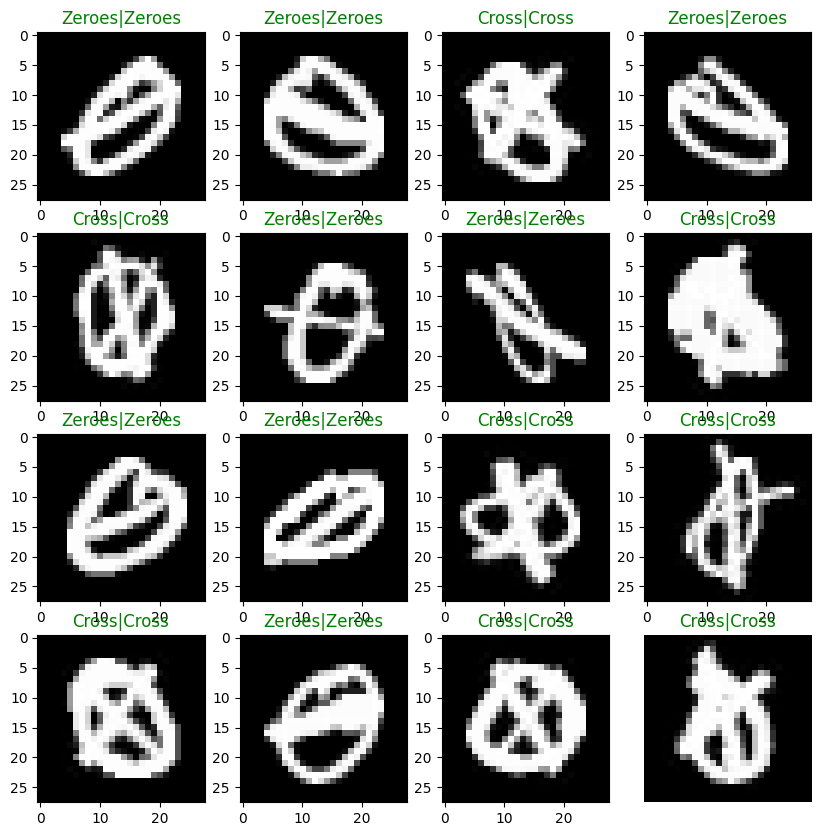

In [797]:
No_of_values_to_predict = 16
plt.figure(figsize=(10,10))
Color = ['r','g']
list_indices = np.random.randint(0,len(train_data),16)
for x in range(16):
    plt.subplot(4,4,x+1)
    plt.imshow(train_data[list_indices[x]][0].squeeze().permute(1,2,0),cmap='gray')
    plt.title(f"{train_data.classes[y_pred[list_indices[x]]]}|{class_names[train_data[list_indices[x]][1]]}",c=Color[is_equal(y_pred[list_indices[x]],train_data.targets[list_indices[x]])])
plt.axis(False)

In [800]:
# torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
            # f="Model_1.pth")
model_2 = model = Model_for_checking_0orX(input_shape=3, 
    hidden_units=100, 
    output_shape=len(train_data.classes))
model_2.load_state_dict(torch.load(f="Model_1.pth"))

<All keys matched successfully>

### SHASHANK AND ANIRVAN READ AFTER THIS

In [801]:
grid_csv = pd.read_csv("icg-freshers-data-science-competition/Dataset/Train/Grid_labels.csv")
grid_csv

,ID,POS_1,POS_2,POS_3,POS_4,POS_5,POS_6,POS_7,POS_8,POS_9,Decisions
0,58,0,0,1,1,1,0,2,2,0,0
1,160,0,0,1,2,2,2,0,1,1,1
2,162,0,0,1,2,2,2,0,2,1,0
3,287,0,0,2,2,0,1,1,1,2,1
4,500,0,1,0,2,1,2,1,0,0,2
5,618,0,1,1,2,0,1,0,0,2,0
6,886,0,2,0,0,2,1,1,0,1,2
7,1250,0,2,2,0,1,2,1,0,1,2
8,1587,1,0,0,2,1,2,1,0,0,0
9,1610,1,0,0,2,2,1,2,0,1,1


In [802]:
grid_csv["ID"][0]

58

In [803]:
# img=cv2.imread(a)
grid_path = Path("icg-freshers-data-science-competition/Dataset/Train/Grids")
blank_image = np.ones((26,26))*30
imagelist=[]
for x in range(len(grid_csv)):
    img_address = str(grid_csv["ID"][x])+".png"
    a = Path.joinpath(grid_path,img_address)
    print(a)
    images_grid1 = cv2.imread(str(a))
    images_grid1=images_grid1[60:420,145:505]
    img2 = images_grid1

    height, width,color_channels = img2.shape

    # Number of pieces Horizontally 
    W_SIZE  = 3 
    # Number of pieces Vertically to each Horizontal  
    H_SIZE = 3

    # Create a list to store sub-images for the current image
    current_image_parts = []

    for ih in range(H_SIZE):
        for iw in range(W_SIZE):
            x = width / W_SIZE * iw 
            y = height / H_SIZE * ih
            h = (height / H_SIZE)
            w = (width / W_SIZE)

            # Extract the sub-image
            img = img2[int(y):int(y + h), int(x):int(x + w)]
            img = cv2.resize(img, (28, 28))
            # Append the sub-image to the list for the current image
            current_image_parts.append(img)

    # Append the list of sub-images to the main list
    imagelist.append(current_image_parts)

icg-freshers-data-science-competition/Dataset/Train/Grids/58.png
icg-freshers-data-science-competition/Dataset/Train/Grids/160.png
icg-freshers-data-science-competition/Dataset/Train/Grids/162.png
icg-freshers-data-science-competition/Dataset/Train/Grids/287.png
icg-freshers-data-science-competition/Dataset/Train/Grids/500.png
icg-freshers-data-science-competition/Dataset/Train/Grids/618.png
icg-freshers-data-science-competition/Dataset/Train/Grids/886.png
icg-freshers-data-science-competition/Dataset/Train/Grids/1250.png
icg-freshers-data-science-competition/Dataset/Train/Grids/1587.png
icg-freshers-data-science-competition/Dataset/Train/Grids/1610.png
icg-freshers-data-science-competition/Dataset/Train/Grids/2154.png
icg-freshers-data-science-competition/Dataset/Train/Grids/2366.png
icg-freshers-data-science-competition/Dataset/Train/Grids/2425.png
icg-freshers-data-science-competition/Dataset/Train/Grids/2587.png
icg-freshers-data-science-competition/Dataset/Train/Grids/2591.png
icg

In [804]:
len(imagelist)

25

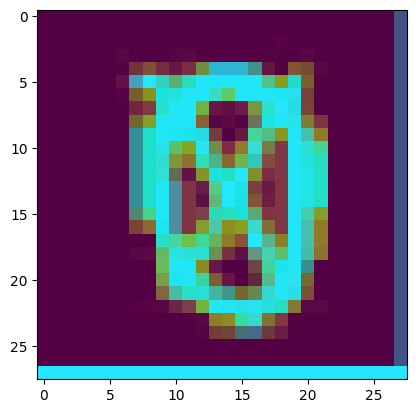

In [805]:
plt.imshow(imagelist[0][0])

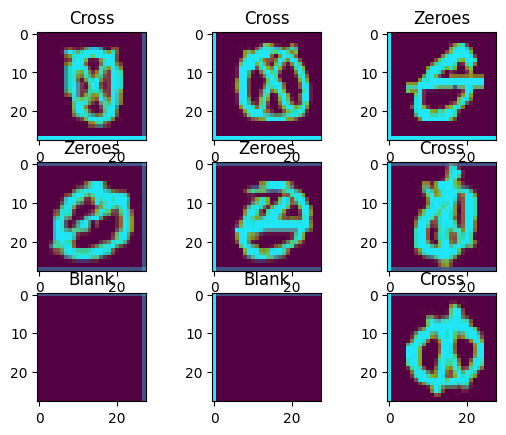

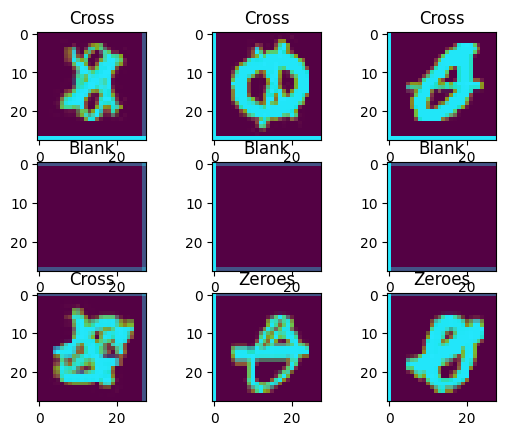

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9a1f3d3f40>
Traceback (most recent call last):
  File "/home/aarush/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/aarush/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1442, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.10/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


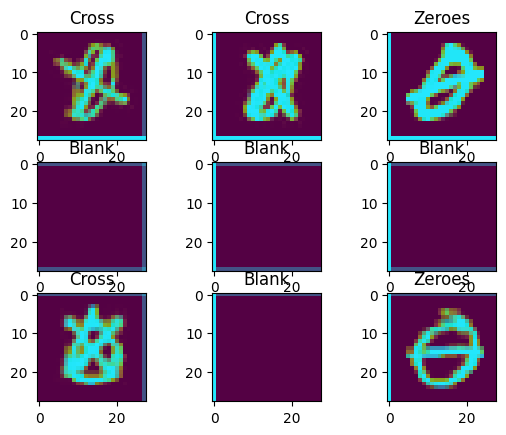

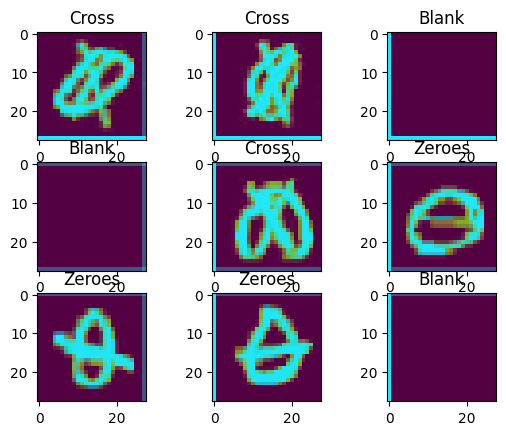

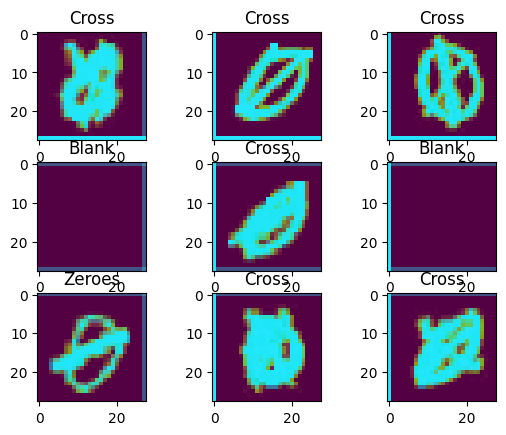

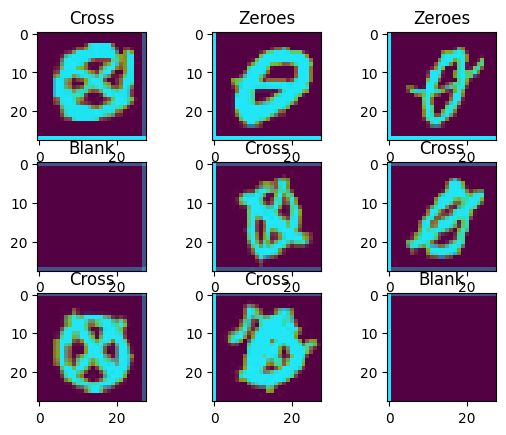

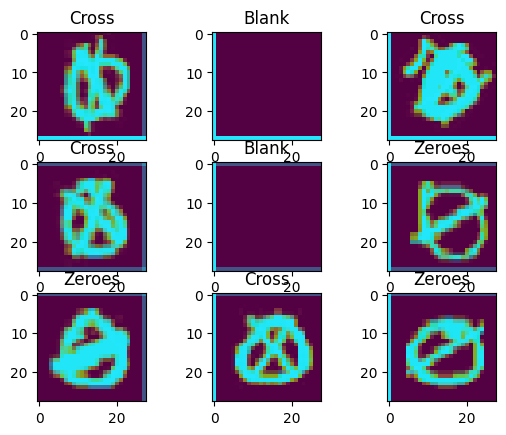

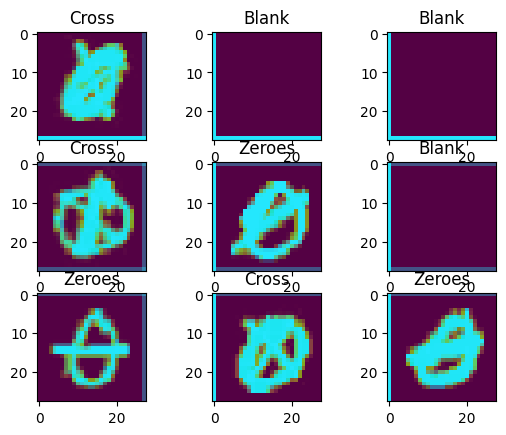

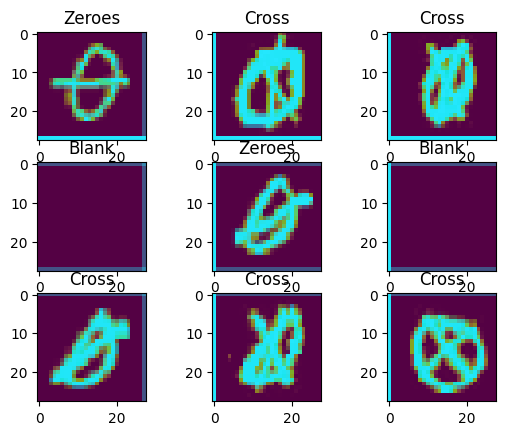

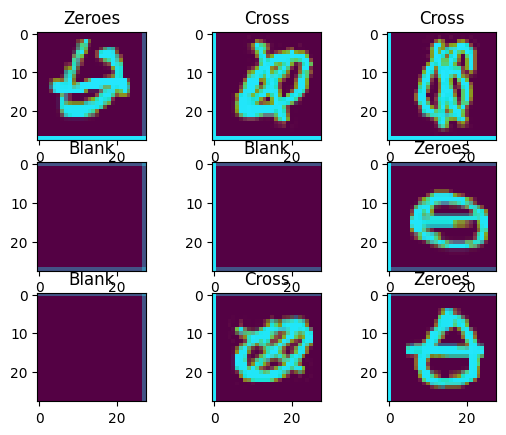

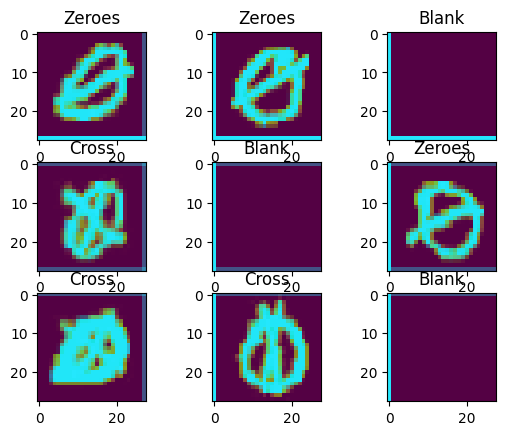

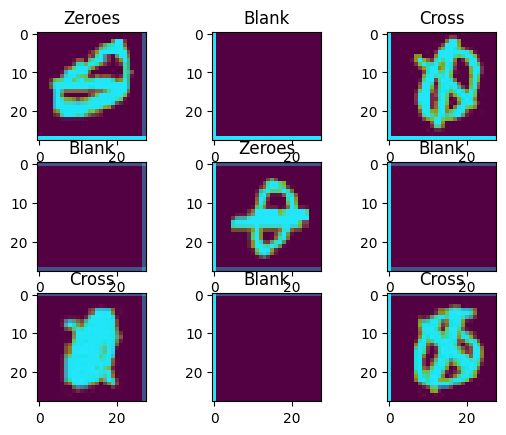

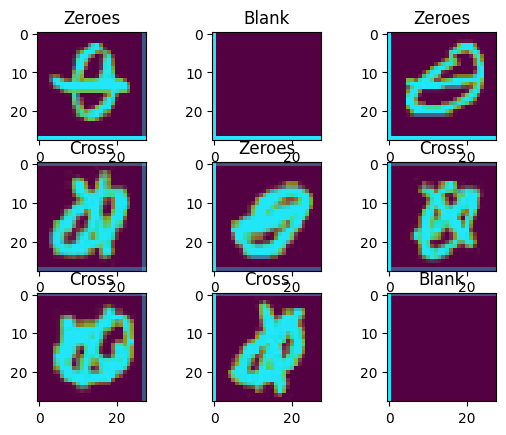

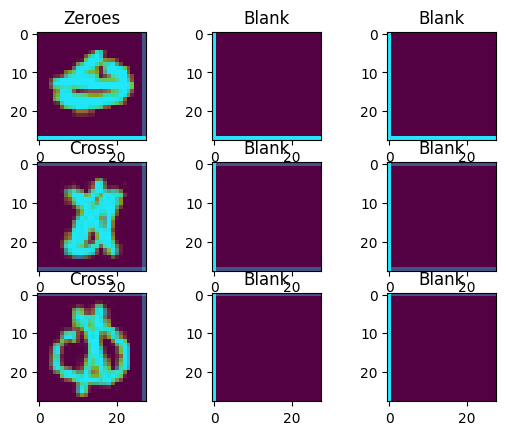

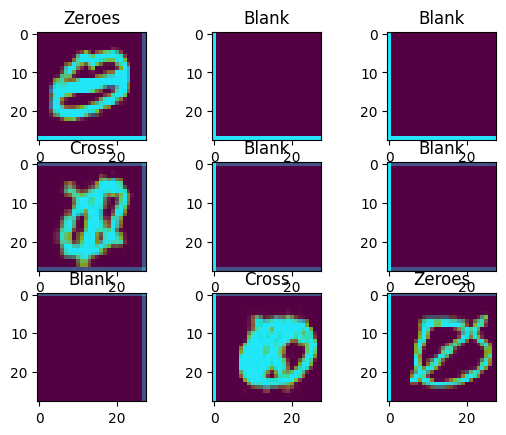

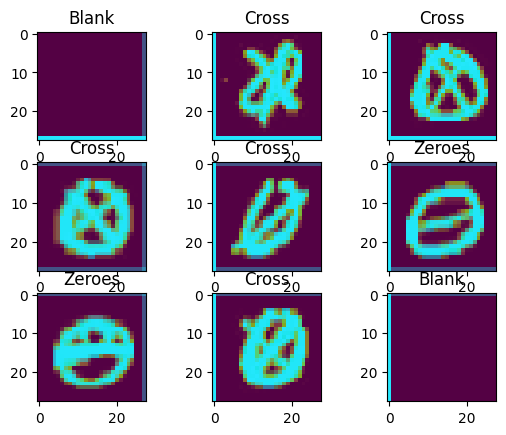

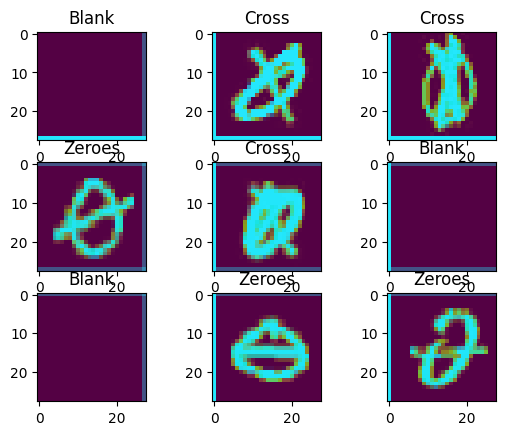

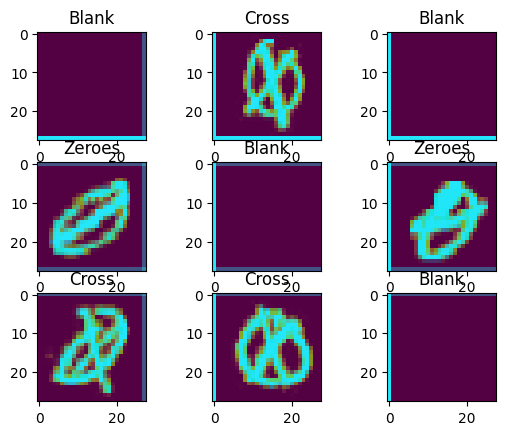

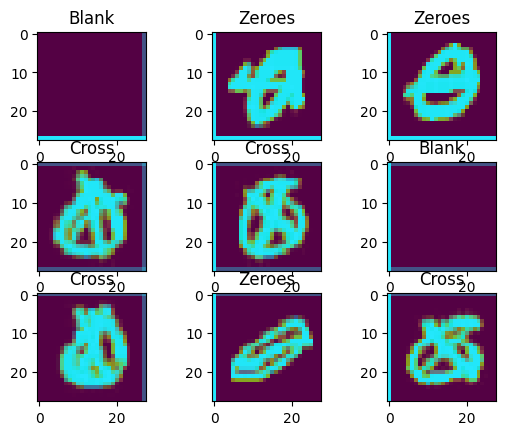

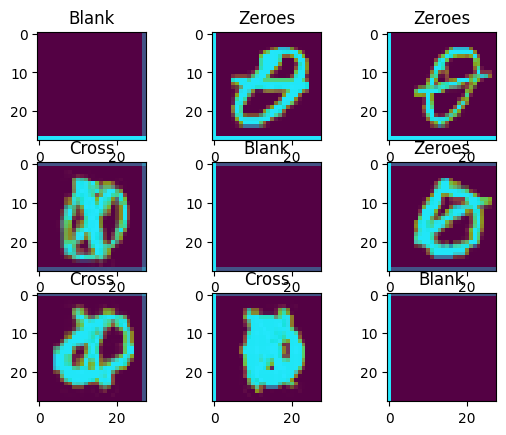

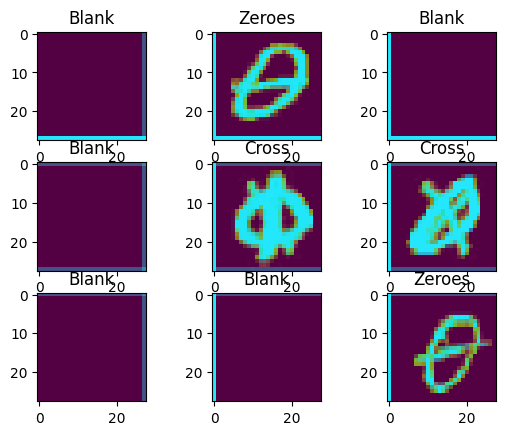

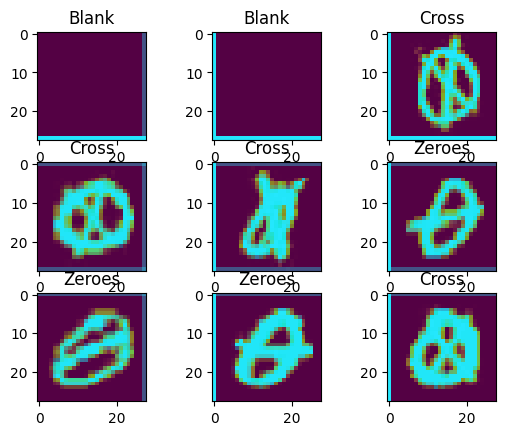

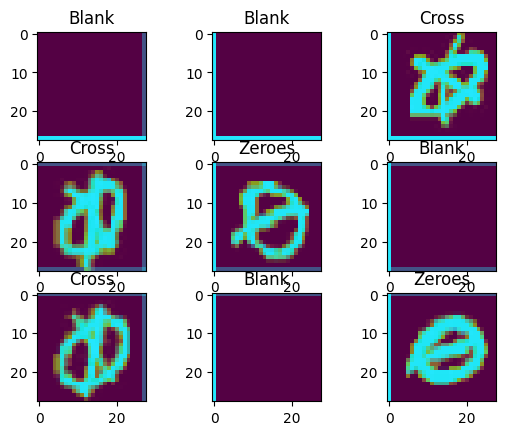

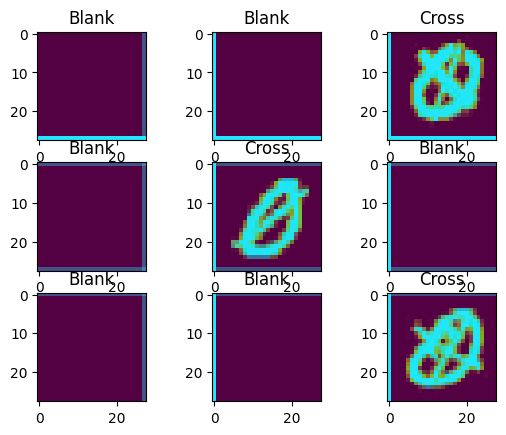

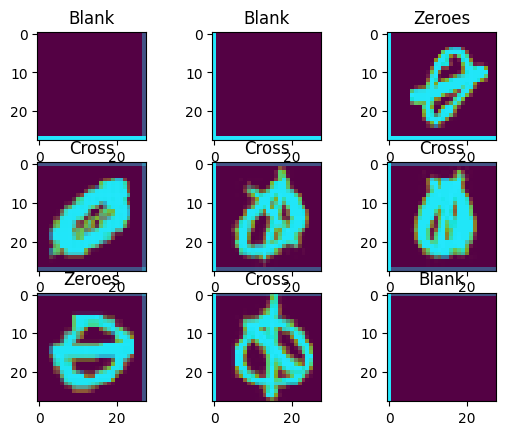

In [806]:
transform = transforms.ToTensor()
for j in range(len(imagelist)):
    for x in range(9):
        plt.subplot(3,3,x+1)
        plt.imshow(imagelist[j][x])
        if np.array_equal(blank_image,cv2.cvtColor(imagelist[j][x][1:27,1:27], cv2.COLOR_BGR2GRAY)):
            plt.title("Blank")
        else:
            y = model(transform(imagelist[j][x]).unsqueeze(0))
            plt.title(class_names[y.argmax(1)])
    plt.show()

In [807]:
grid_csv.index = np.arange(1,26)
grid_csv

,ID,POS_1,POS_2,POS_3,POS_4,POS_5,POS_6,POS_7,POS_8,POS_9,Decisions
1,58,0,0,1,1,1,0,2,2,0,0
2,160,0,0,1,2,2,2,0,1,1,1
3,162,0,0,1,2,2,2,0,2,1,0
4,287,0,0,2,2,0,1,1,1,2,1
5,500,0,1,0,2,1,2,1,0,0,2
6,618,0,1,1,2,0,1,0,0,2,0
7,886,0,2,0,0,2,1,1,0,1,2
8,1250,0,2,2,0,1,2,1,0,1,2
9,1587,1,0,0,2,1,2,1,0,0,0
10,1610,1,0,0,2,2,1,2,0,1,1


In [808]:
list_map = []
for x in range(25):
    for y in range(9):
        if grid_csv.iloc[x,y+1] !=2:
            list_map.append([imagelist[x][y],grid_csv.iloc[x,y+1]])

In [809]:
class_names

['Cross', 'Zeroes']

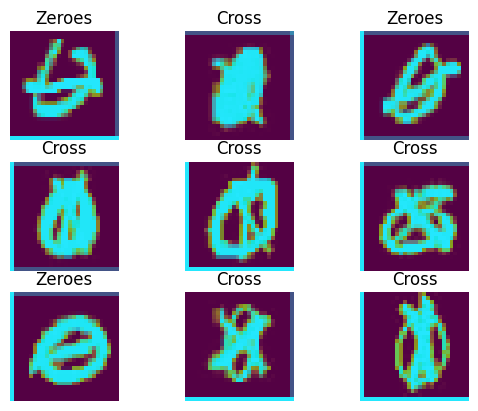

In [810]:
random_indices = np.random.randint(1,len(list_map),(9))
count = 1
for x in random_indices:
    plt.subplot(3,3,count)
    count +=1
    plt.imshow(list_map[x][0])
    plt.title(class_names[list_map[x][1]])
    plt.axis('off')
plt.show()

In [811]:
model(transform(list_map[0][0]).unsqueeze(0)).argmax(1)

tensor([0])

In [812]:
torch.tensor(list_map[x][0]).permute(2,0,1).unsqueeze(0).shape

torch.Size([1, 3, 28, 28])

In [813]:
def accuracy_function(y_pred,y):
    return torch.eq(y_pred.argmax(1),y).sum().item()*100

In [814]:
images = []
labels= []
for x in list_map:
    images.append(Image.fromarray(x[0]))
    labels.append(x[1])

In [815]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.images)
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label)  # Convert label to tensor if it's not already

# Example usage:

# Assuming you have lists of image paths and labels
# Define transformations for image preprocessing

# Create a custom dataset

custom_dataset = CustomDataset(images, labels, transform=data_transform)

# Create a DataLoader to handle batching and shuffling
batch_size = 32
shuffle = True
num_workers = 4  # Number of CPU processes to use for data loading
data_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

# Iterate through the DataLoader during training


In [819]:
train_loss, train_acc = 0, 0
epochs = 5
for epoch in range(epochs):
    train_loss = 0
    train_accuracy = 0
    for Batch,(X,y) in enumerate(iter(data_loader)):
        model.train()
        y_pred = model(X)
        loss = loss_fn(y_pred,y)
        train_loss +=loss
        accuracy = accuracy_function(y_pred,y) 
        train_accuracy+=accuracy
        optimizer.zero_grad()
        loss.backward()
        # print(loss)
        optimizer.step()
    print(f"\n{epoch}|Average loss: {(train_loss/len(images))}|Average Accuracy:{(train_accuracy/len(images)):.2f}%\n")


0|Average loss: 0.0056034293957054615|Average Accuracy:94.48%


1|Average loss: 0.005690744612365961|Average Accuracy:94.48%


2|Average loss: 0.005801285617053509|Average Accuracy:94.48%


3|Average loss: 0.005053078290075064|Average Accuracy:96.55%


4|Average loss: 0.005436294712126255|Average Accuracy:95.17%



In [820]:
# torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
#             f="Model_1.pth")

In [733]:
y_pred

tensor([[ 0.5269, -0.5109]], grad_fn=<AddmmBackward0>)

In [821]:
X,y =list_map[0]
y = torch.tensor(y)
y

tensor(0)

In [822]:


grid_csv.iloc[0,2]

0

In [823]:
y_expected = np.array(grid_csv['Decisions'])

In [824]:
y_expected = torch.tensor(y_expected)

In [825]:
X  = [] 
for x in range(len(grid_csv)):
    X.append(grid_csv.iloc[1,1:10])

In [826]:
len(X)

25

In [827]:
X = []
for x in range(0,25):
    X.append(torch.tensor(grid_csv.iloc[x,1:10],dtype=torch.float))

/tmp/ipykernel_4927/1477014975.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X.append(torch.tensor(grid_csv.iloc[x,1:10],dtype=torch.float))


In [828]:
len(X)

25

In [829]:
nn.Flatten()

Flatten(start_dim=1, end_dim=-1)

In [830]:
class Model_Who_will_win(nn.Module):
    def __init__(self,input_features,hidden_units,output_features) -> None:
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            # nn.Flatten(),
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

In [831]:
model_predict = Model_Who_will_win(9,1000,3)

In [832]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_predict.parameters(), 
                            lr=0.00001)

In [833]:
torch.tensor(grid_csv.iloc[1,1:10])

/tmp/ipykernel_4927/3667532071.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  torch.tensor(grid_csv.iloc[1,1:10])


tensor([0, 0, 1, 2, 2, 2, 0, 1, 1])

In [834]:
model_predict(X[0])


tensor([-0.0416, -0.0450,  0.0582], grad_fn=<ViewBackward0>)

In [835]:
def accuracy_function(y_pred,y):
    return torch.eq(y_pred,y).sum().item()/len(y_pred)*100

In [836]:
y_pred.shape

torch.Size([17, 2])

In [837]:
epochs = 1000
for epoch in range(epochs):
    y_pred = []
    total_loss,total_acc = 0,0
    for x in range(len(X)):
        # 1. Forward pass
        y_logits = model_predict(X[x]) # model outputs raw logits 
        y_pred.append(y_logits.argmax(0)) # go from logits -> prediction probabilities -> prediction labels
        # print(y_logits)
        # 2. Calculate loss and accuracy
        # y_pred = torch.tensor(y_pred,dtype = torch.float,requires_grad=True)
        loss = loss_fn(y_logits, y_expected[x])
        total_loss += loss 


        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backwards
        loss.backward()

        # 5. Optimizer step
        optimizer.step()
    y_pred = torch.tensor(y_pred,dtype=torch.float)
    y_pred.shape
    acc = accuracy_function(y=y_expected,y_pred=y_pred)
    print(f"Epoch: {epoch} | Loss: {total_loss:.5f}, Acc: {acc:.2f}% ") 

Epoch: 0 | Loss: 27.92822, Acc: 24.00% 
Epoch: 1 | Loss: 27.89158, Acc: 24.00% 
Epoch: 2 | Loss: 27.85556, Acc: 24.00% 


Epoch: 3 | Loss: 27.82015, Acc: 28.00% 
Epoch: 4 | Loss: 27.78534, Acc: 28.00% 
Epoch: 5 | Loss: 27.75111, Acc: 32.00% 
Epoch: 6 | Loss: 27.71745, Acc: 32.00% 
Epoch: 7 | Loss: 27.68435, Acc: 32.00% 
Epoch: 8 | Loss: 27.65179, Acc: 32.00% 
Epoch: 9 | Loss: 27.61976, Acc: 40.00% 
Epoch: 10 | Loss: 27.58825, Acc: 40.00% 
Epoch: 11 | Loss: 27.55725, Acc: 40.00% 
Epoch: 12 | Loss: 27.52674, Acc: 40.00% 
Epoch: 13 | Loss: 27.49673, Acc: 40.00% 
Epoch: 14 | Loss: 27.46717, Acc: 40.00% 
Epoch: 15 | Loss: 27.43809, Acc: 40.00% 
Epoch: 16 | Loss: 27.40946, Acc: 40.00% 
Epoch: 17 | Loss: 27.38127, Acc: 44.00% 
Epoch: 18 | Loss: 27.35351, Acc: 40.00% 
Epoch: 19 | Loss: 27.32617, Acc: 40.00% 
Epoch: 20 | Loss: 27.29925, Acc: 40.00% 
Epoch: 21 | Loss: 27.27274, Acc: 40.00% 
Epoch: 22 | Loss: 27.24661, Acc: 40.00% 
Epoch: 23 | Loss: 27.22087, Acc: 40.00% 
Epoch: 24 | Loss: 27.19551, Acc: 40.00% 
Epoch: 25 | Loss: 27.17052, Acc: 44.00% 
Epoch: 26 | Loss: 27.14589, Acc: 44.00% 
Epoch: 27 | Loss: 27.12

KeyboardInterrupt: 

In [840]:
model_predict.load_state_dict(torch.load(f= 'Model_win_or_lose.pth'))

<All keys matched successfully>

In [ ]:
# torch.save(obj=model_predict.state_dict(), # only saving the state_dict() only saves the learned parameters
#            f="Model_win_or_lose.pth")

In [841]:
submition = pd.read_csv('icg-freshers-data-science-competition/Dataset/Sample_submission.csv')
submition.head()

,ID,POS_1,POS_2,POS_3,POS_4,POS_5,POS_6,POS_7,POS_8,POS_9,Decision
0,0,2,2,2,2,2,2,2,2,2,0
1,1,2,2,2,2,2,2,2,2,2,0
2,2,2,2,2,2,2,2,2,2,2,0
3,3,2,2,2,2,2,2,2,2,2,0
4,4,2,2,2,2,2,2,2,2,2,0


In [851]:
predictions = []
for x in range(len(submition)):
    predictions.append(model_predict(torch.tensor(submition.iloc[0,1:10],dtype=torch.float)).argmax(0))

/tmp/ipykernel_4927/1558109329.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predictions.append(model_predict(torch.tensor(submition.iloc[0,1:10],dtype=torch.float)).argmax(0))


In [852]:
predictions[:10]

[tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1)]